<a href="https://colab.research.google.com/github/zainamri/Kelompok-3-/blob/main/kalsifikasi_Pproject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Mengimpor pustaka yang diperlukan
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier, plot_importance
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
from google.colab import drive

# Menghubungkan Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Akses dataset
file_path = '/content/drive/MyDrive/datasetdah/heart_failure_clinical_records_dataset.csv'
data = pd.read_csv(file_path)

# Menampilkan beberapa baris pertama dari dataset
data.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


# Pra-pemrosesan Data

In [ ]:
# Mengonversi kolom integer yang berisi 0 dan 1 menjadi boolean
kolom_biner = ['anaemia', 'diabetes', 'high_blood_pressure', 'sex', 'smoking', 'DEATH_EVENT']
data[kolom_biner] = data[kolom_biner].astype(bool)

# Memeriksa nilai yang hilang
if data.isnull().sum().sum() > 0:
    print("Nilai yang hilang ditemukan!")
else:
    print("Tidak ada nilai yang hilang dalam DataFrame!")

Tidak ada nilai yang hilang dalam DataFrame!


In [ ]:
# Mendeteksi outlier menggunakan Z-score
def deteksi_outlier_zscore(data, kolom, threshold=3):
    info_outlier = {}
    for col in kolom:
        z_scores = stats.zscore(data[col].dropna())
        outliers = np.abs(z_scores) > threshold
        info_outlier[col] = data[col][outliers].tolist()
    return info_outlier

# Mendeteksi outlier di kolom numerik
kolom_numerik = ['creatinine_phosphokinase', 'ejection_fraction', 'platelets', 'serum_creatinine', 'serum_sodium', 'time']
outliers = deteksi_outlier_zscore(data, kolom_numerik)
print("Outlier yang terdeteksi:", outliers)

Outlier yang terdeteksi: {'creatinine_phosphokinase': [7861, 3964, 7702, 5882, 5209, 4540, 3966], 'ejection_fraction': [80], 'platelets': [621000.0, 850000.0, 742000.0], 'serum_creatinine': [9.4, 5.8, 6.8, 6.1, 9.0, 5.0], 'serum_sodium': [116, 121, 113], 'time': []}


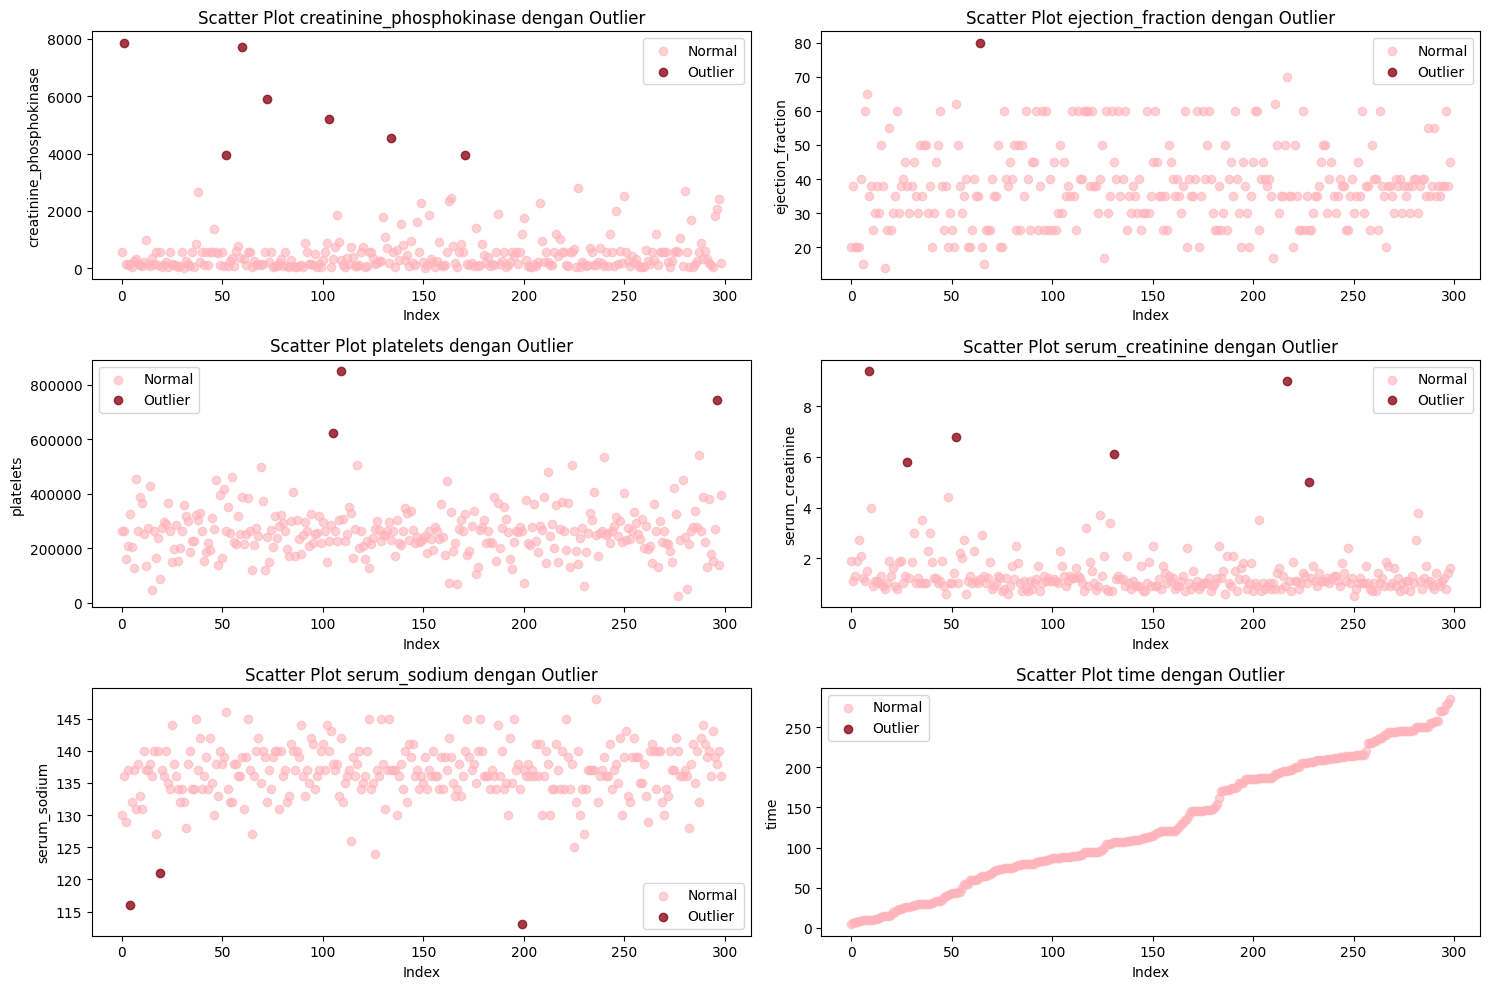

In [ ]:
# Visualisasi outlier dengan scatter plot
def plot_outliers(data, kolom, outliers_info):
    plt.figure(figsize=(15, 10))

    for i, col in enumerate(kolom):
        plt.subplot(3, 2, i + 1)

        # Menentukan warna pastel
        pastel_color = '#FFB3BA'  # Warna untuk data normal
        outlier_color = '#8B0A1A'  # Warna untuk outlier

        # Menandai outlier
        is_outlier = data[col].isin(outliers_info[col])

        # Scatter plot
        plt.scatter(data.index[~is_outlier], data[col][~is_outlier], color=pastel_color, label='Normal', alpha=0.6)
        plt.scatter(data.index[is_outlier], data[col][is_outlier], color=outlier_color, label='Outlier', alpha=0.8)

        plt.title(f'Scatter Plot {col} dengan Outlier')
        plt.xlabel('Index')
        plt.ylabel(col)
        plt.legend()

    plt.tight_layout()
    plt.show()

# Memanggil fungsi untuk memvisualisasikan outlier
plot_outliers(data, kolom_numerik, outliers)

In [ ]:
# Menangani outlier untuk semua kolom numerik
def handle_outliers(df, kolom):
    for col in kolom:
        # Menghitung batas atas dan bawah menggunakan IQR
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1

        # Menentukan batas untuk outlier
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Meng-capping outlier
        df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
        df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])

    return df

# Menangani outlier di DataFrame
data = handle_outliers(data, kolom_numerik)

In [ ]:
# Pemilihan fitur dan target
X = data.drop(columns=['DEATH_EVENT'])
y = data['DEATH_EVENT']

# Membagi dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

In [ ]:
# Normalisasi fitur numerik
fitur_numerik = X.select_dtypes(include=['float64', 'int64']).columns
scaler = MinMaxScaler()
X_train[fitur_numerik] = scaler.fit_transform(X_train[fitur_numerik])
X_test[fitur_numerik] = scaler.transform(X_test[fitur_numerik])

In [ ]:
# Inisialisasi model
models = {
    'Regresi Logistik': LogisticRegression(max_iter=1000),
    'AdaBoost': AdaBoostClassifier(),
    'XGBoost': XGBClassifier(eval_metric='logloss')  # Hapus use_label_encoder
}

Model: Regresi Logistik
Akurasi: 0.77


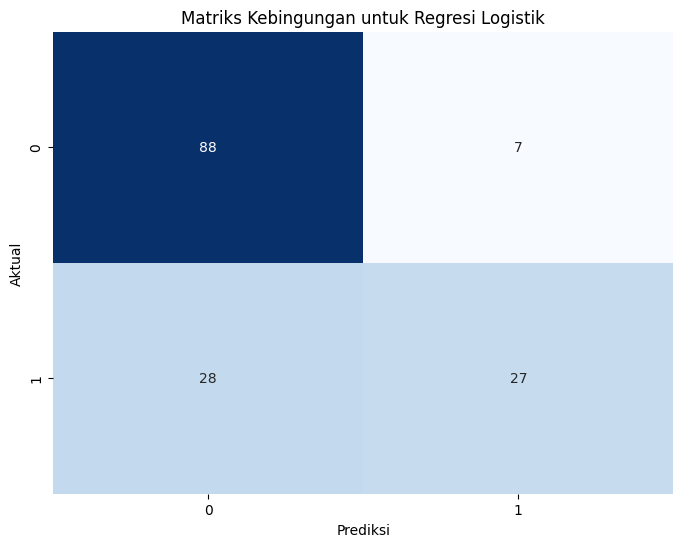

Laporan Klasifikasi:
              precision    recall  f1-score   support

       False       0.76      0.93      0.83        95
        True       0.79      0.49      0.61        55

    accuracy                           0.77       150
   macro avg       0.78      0.71      0.72       150
weighted avg       0.77      0.77      0.75       150





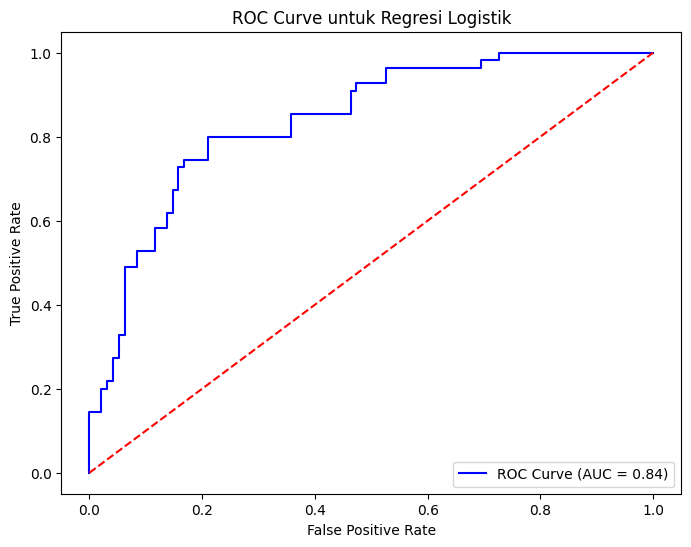

Model: AdaBoost
Akurasi: 0.79


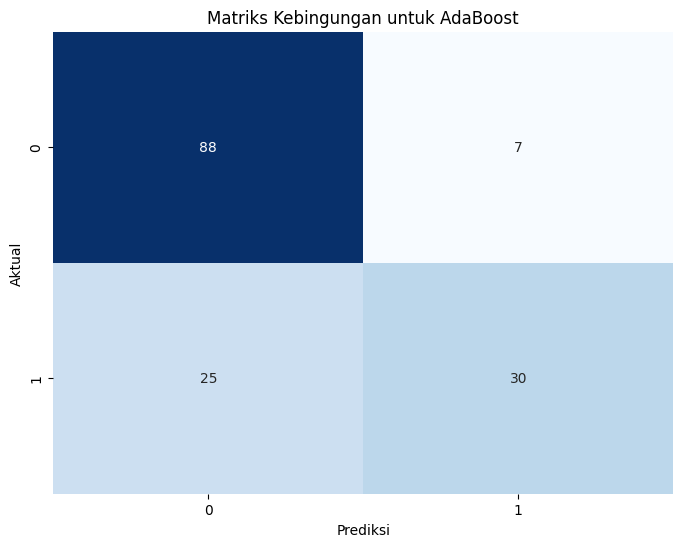

Laporan Klasifikasi:
              precision    recall  f1-score   support

       False       0.78      0.93      0.85        95
        True       0.81      0.55      0.65        55

    accuracy                           0.79       150
   macro avg       0.79      0.74      0.75       150
weighted avg       0.79      0.79      0.78       150





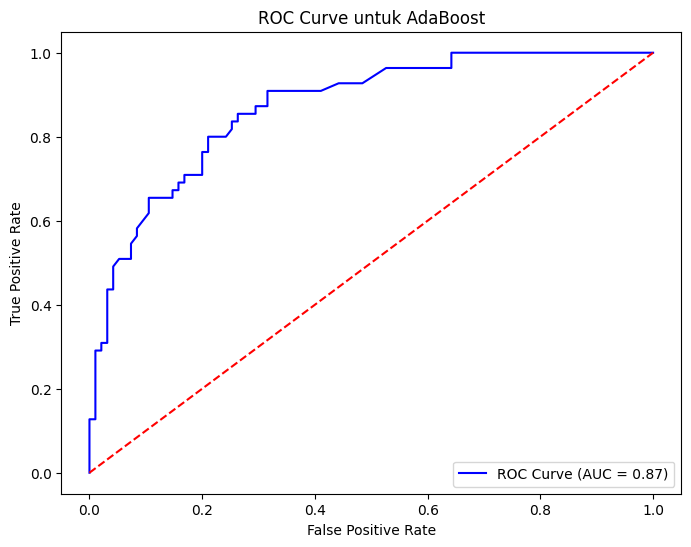

Model: XGBoost
Akurasi: 0.77


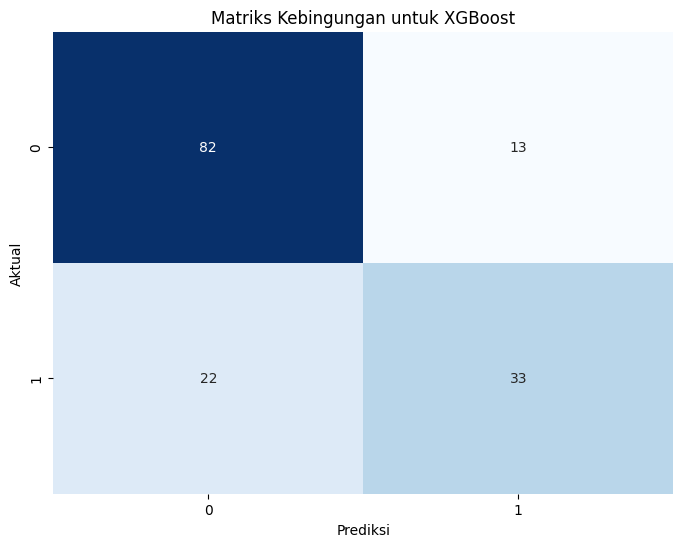

Laporan Klasifikasi:
              precision    recall  f1-score   support

       False       0.79      0.86      0.82        95
        True       0.72      0.60      0.65        55

    accuracy                           0.77       150
   macro avg       0.75      0.73      0.74       150
weighted avg       0.76      0.77      0.76       150





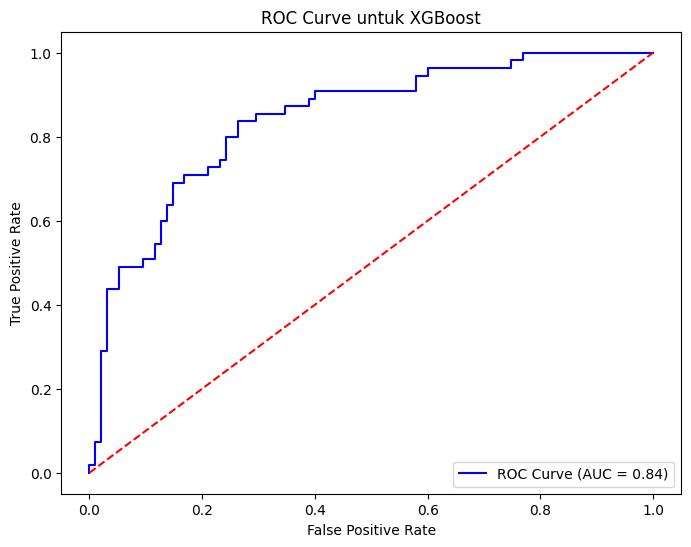

<Figure size 1000x600 with 0 Axes>

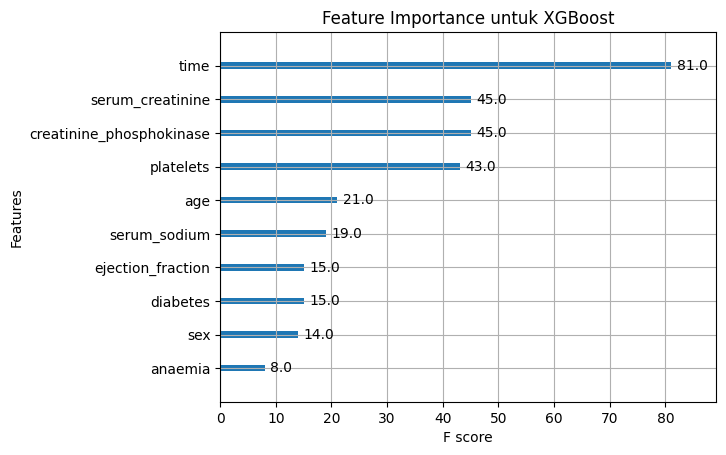

In [ ]:
# Melatih dan mengevaluasi setiap model dengan visualisasi matriks kebingungan
def plot_confusion_matrix(cm, model_name):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Matriks Kebingungan untuk {model_name}')
    plt.xlabel('Prediksi')
    plt.ylabel('Aktual')
    plt.show()

for nama, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print(f"Model: {nama}")
    print(f"Akurasi: {accuracy_score(y_test, y_pred):.2f}")

    # Matriks kebingungan
    cm = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(cm, nama)

    print("Laporan Klasifikasi:")
    print(classification_report(y_test, y_pred))
    print("\n")

    # Visualisasi ROC Curve
    y_prob = model.predict_proba(X_test)[:, 1]  # Probabilitas untuk kelas positif
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Garis diagonal
    plt.title(f'ROC Curve untuk {nama}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.show()

    # Visualisasi Feature Importance untuk XGBoost
    if nama == 'XGBoost':
        plt.figure(figsize=(10, 6))
        plot_importance(model, importance_type='weight', max_num_features=10)
        plt.title('Feature Importance untuk XGBoost')
        plt.show()